In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import inspect
import random
import shutil

from datetime import datetime
from dateutil.relativedelta import relativedelta

from scipy import optimize, ndimage
from sklearn import decomposition, cluster, model_selection, metrics
import sklearn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import utils.dataset_utils as dataset
import utils.train_utils as train

import numpy.polynomial.polynomial as poly
from scipy.signal import argrelextrema

In [20]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

def split_Raman_af(X):
    """
    Removing spikes from the data to extract the autofluorescence.
    This is done by applying smoothing filter to the data and then taking the min of the smoothing filter and original data.
    """
    a = X
    c = 50

    # remove the top of the spikes from data, by using a Gaussian smoothing filter
    for _ in range(5):      
        a[:,c] = X[:,c]
        a[:,-c] = X[:,-c]      
        a1 = ndimage.gaussian_filter(a, (0, 30), mode='nearest')
        a = np.min([a, a1], axis=0)

    # remove the spikes from data, by using a polynominal fit
    for _ in range(5):
        a[:,c] = X[:,c]
        a[:,-c] = X[:,-c]        
        z = poly.polyfit(wavelength[::5], a[:,::5].T, 5)
        a1 = poly.polyval(wavelength, z)
        a = np.min([a, a1], axis=0)
        
    # smooth the curve the data, (to remove remnants of noise in the photoluminescence signal)
    for _ in range(10):           
        a[:,1] = X[:,1]
        a[:,-1] = X[:,-1]         
        a = ndimage.gaussian_filter(a, (0, 10), mode='nearest')

    # make the Raman signal non-negative, (to remove remnants of noise in the Raman signal)
    return (X-a).clip(min=0), a 

def smoothing(X, smooth=5, transition=10, spike_width=7):
    """
    Only remove noise from low noise to signal area's to maintain the intensity of the spikes.
    Noise is removed with a gaussian filter in spectral dimension.
    """
    grad = ndimage.gaussian_filter(X, (0, 1), order=1)
    grad_abs = np.abs(grad)
    grad_abs_sm = ndimage.gaussian_filter(grad_abs, (0, 5))
    mean_grad = np.mean(grad_abs, 1) + 1 / np.std(grad_abs, 1) * 3
    
    spikes = ((grad_abs_sm.T > mean_grad ).astype(float)).T 
    spikes = np.round(ndimage.gaussian_filter(spikes, (0, spike_width)))
    spikes = ndimage.uniform_filter(spikes, (0, transition))
    
    return (1 - spikes) * ndimage.gaussian_filter(X, (0,smooth)) + spikes * X

def split_Raman_af2(X):
    tmp = []
    for x in X:
        index = argrelextrema(x, np.less, order=5)[0]
#         index = index[argrelextrema(x[index], np.less, order=1)[0]]
        cons = np.polynomial.polynomial.polyfit(wavelength[index], x[index], 5, full=False)
        tmp.append(np.polynomial.polynomial.polyval(wavelength, cons))
    a = np.array(tmp)       
    return X-a, a

def smoothing2(X, smooth=5):
    """
    Only remove noise from low noise to signal area's to maintain the intensity of the spikes.
    Noise is removed with a gaussian filter in spectral dimension.
    """
    return ndimage.gaussian_filter(X, (0, smooth))

In [21]:
N_WAVE = 2126

Y = np.load("../data/Raman/Alina_Art_4_2.npy", 'r')

wavelength = np.load("../data/Raman/wavelength.npy", 'r')

shape_Y = Y.shape

Y = copy.copy(Y.reshape(-1, Y.shape[-1]))
Y_smooth = smoothing(Y)
Y_smooth2 = smoothing2(Y)

ram_Y1, afl_Y1 = split_Raman_af(Y_smooth)
ram_Y2, afl_Y2 = split_Raman_af2(Y)
ram_Y3, afl_Y3 = split_Raman_af2(Y_smooth2)

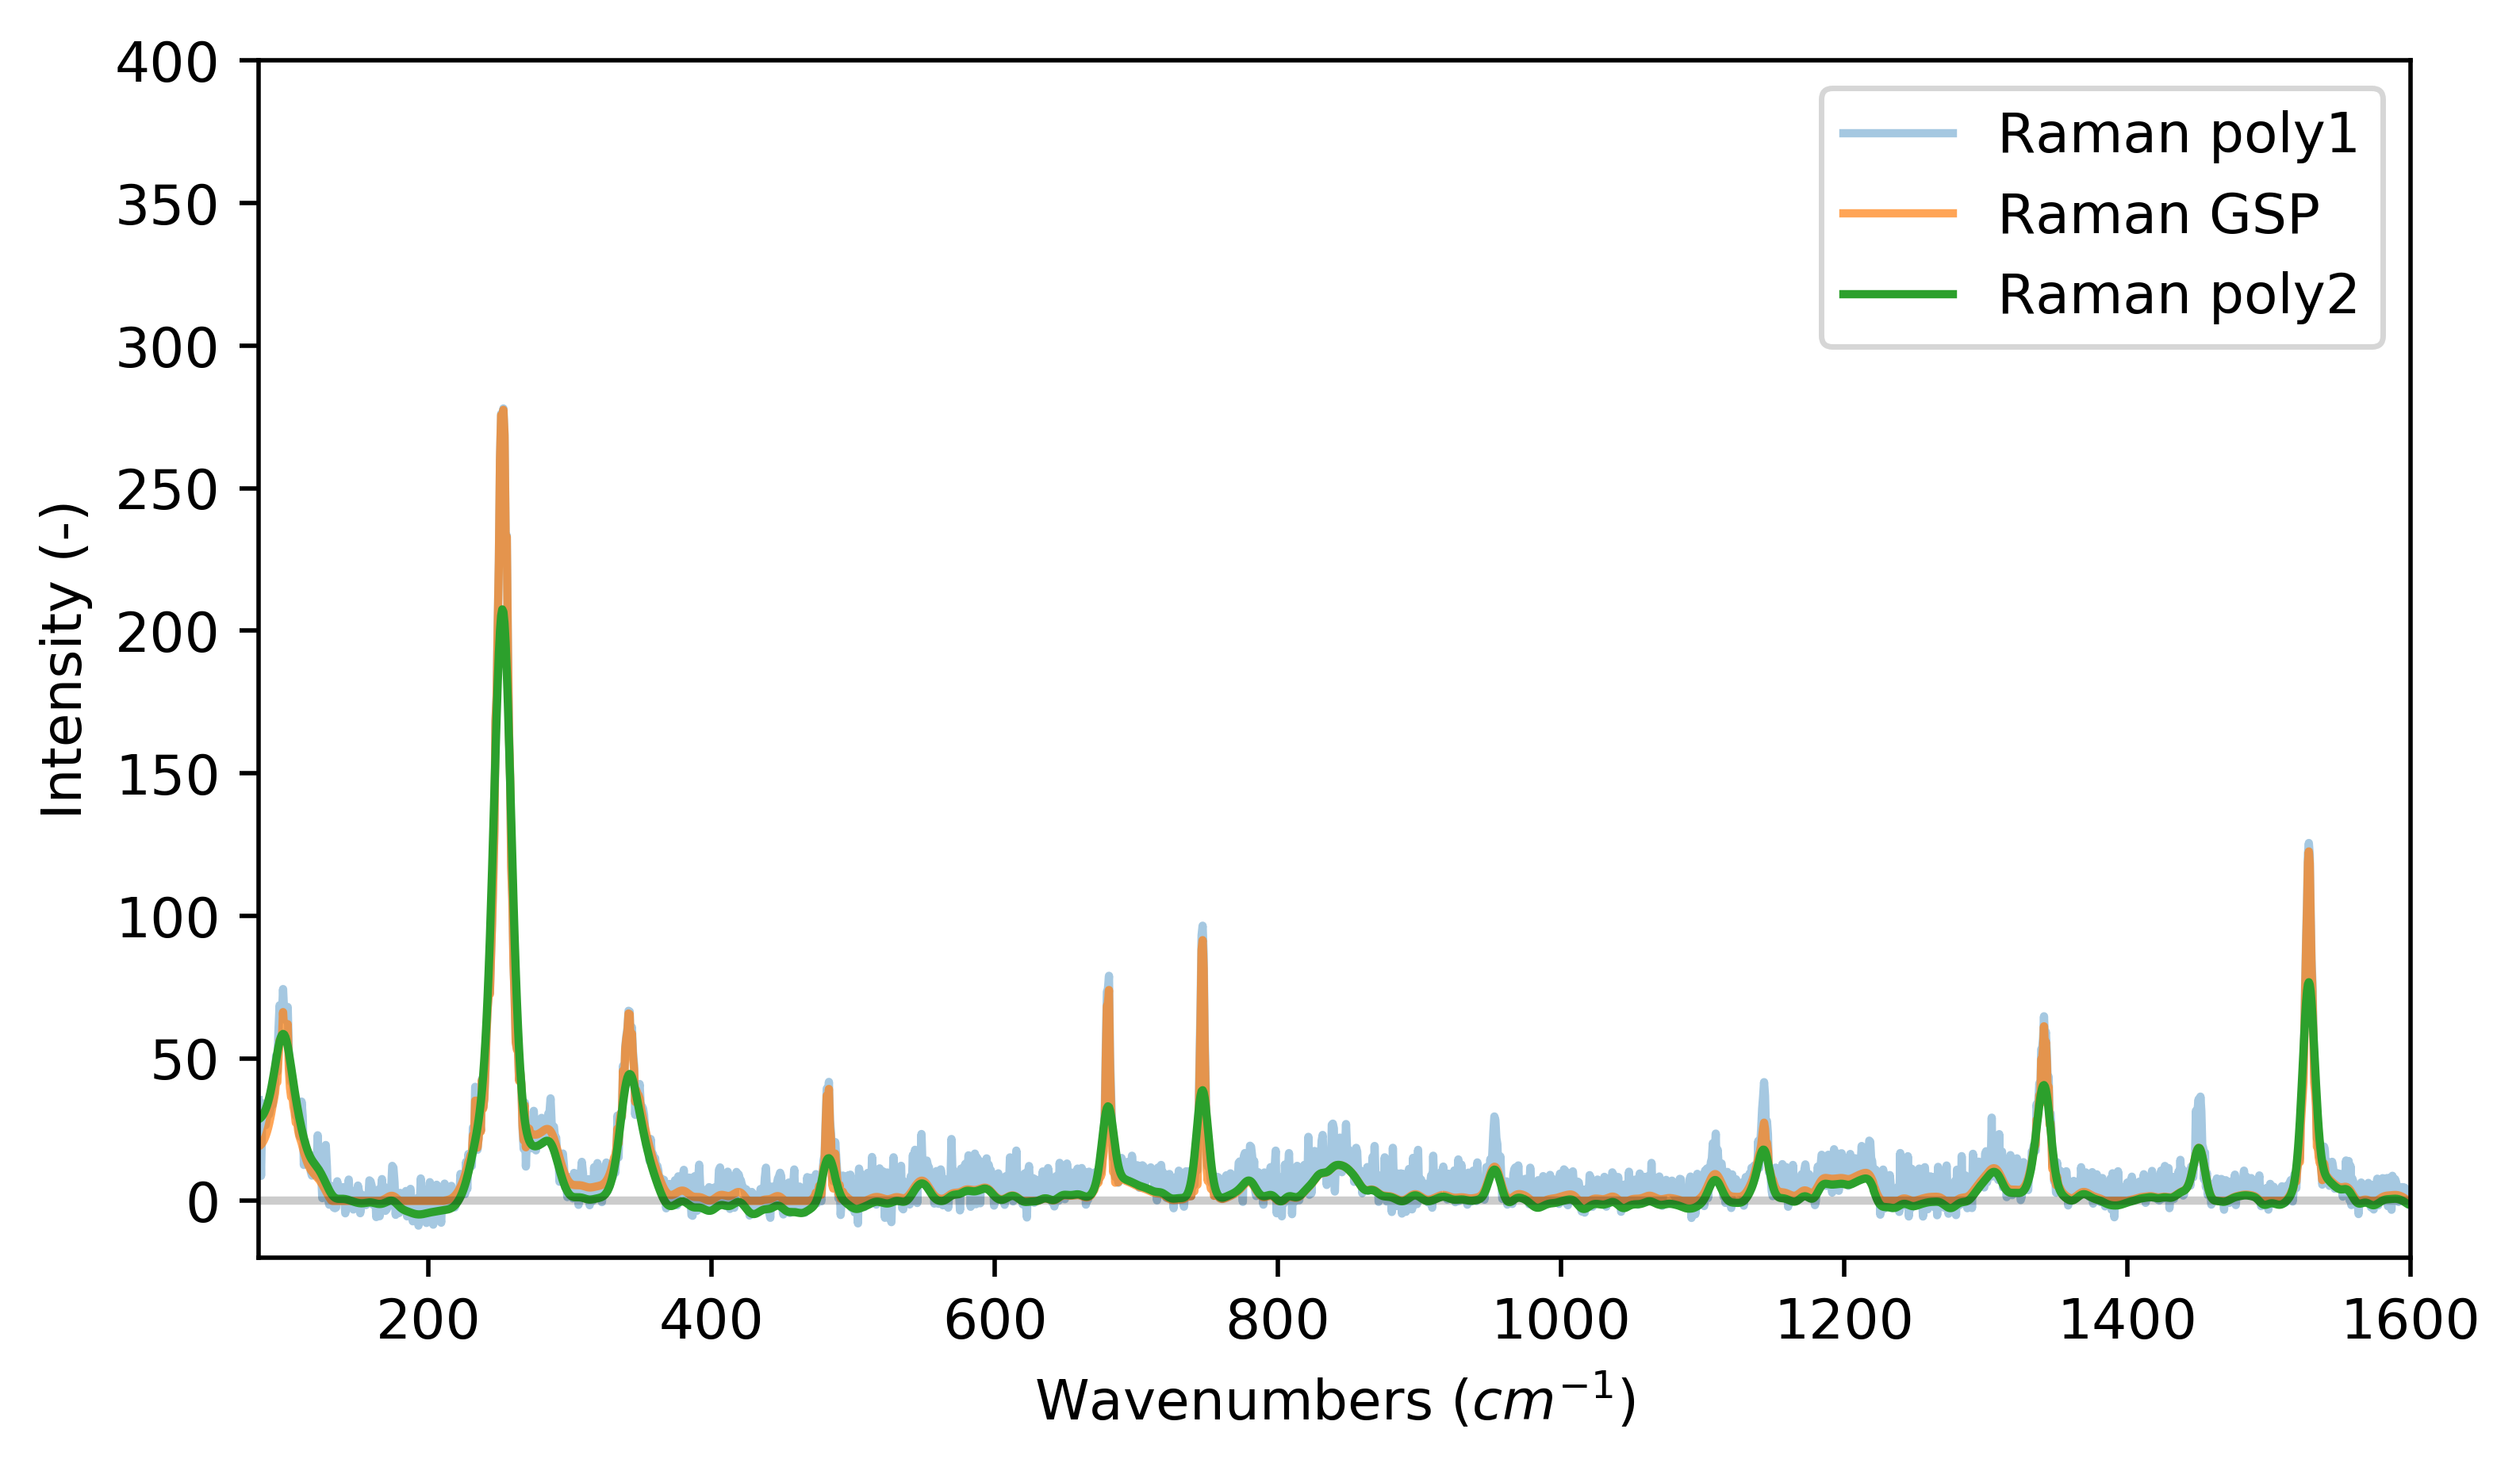

In [23]:
# i = 3025
# i = 5458
i = 5703
# i = 4563

plt.figure(figsize = (7,4), dpi=500)
axes = plt.gca()
plt.plot(wavelength, ram_Y2[i], label='Raman poly1', alpha=0.4)
plt.plot(wavelength, ram_Y1[i], label='Raman GSP', alpha=0.7)
plt.plot(wavelength, ram_Y3[i], label='Raman poly2')
plt.ylabel("Intensity (-)")
plt.xlabel("Wavenumbers ($cm^{-1}$)")
axes.set_xlim([80,1600])
axes.set_ylim([-20,400])
axes.axhline(y=0, color='k', alpha=0.2)
plt.legend()
plt.show()